Senescent signatures are characteristic sets of molecular and phenotypic markers—often including specific gene expression patterns, protein biomarkers, and secreted factors—that distinguish senescent cells from normal, proliferating, or quiescent cells. These signatures are used to identify, quantify, and study senescent cell populations both in vitro and in vivo.

For starters I will use SenMayo:

It is a comprehensive gene set of 125 genes, primarily composed of SASP factors, transmembrane and intracellular proteins. It reliably identifies senescent cells across tissues and species and outperforms existing senescence/SASP gene panels. Key genes include inflammatory cytokines (IL1A, CXCL8), proteases (MMP2), and regulators like IGF1. SenMayo can characterize senescent cells at the single-cell level and track their clearance.

The reason behind starting with SenMayo is because we are using single cell RNA data from SmartSeq2 sequencing from Liver. This technique allwos the capture of full-length transcripts from individual cells with high sensitivity and accuracy. It is excellent for detecting low abundance and alternatively spliced transcripts and provides detailed information on transcript isoforms. An excelent technique to investigate the presence of senescence marker genes.

I will also try a different senescent signature, CellAge.

A curated database and gene set of genes driving or associated with cellular senescence used to identify senescence-related pathways and genetic programs in cells.

CellAge is a human derived senescent gene set signature, just like SenMayo, but unlike the previous signature it does not have a readily available file with mice orthologs for my utilization. Based on this the mapping will have to be done first between the human CellAge genes to the mouse orthologs.

A third senescent signature will be Hernandez-Segura: 

Transcriptomic profiles defining distinct senescence states depending on senescence inducers and cell types, highlighting heterogeneity in senescent cell gene expression.

None of these three signatures were constructed with single cell RNA sequencing. SenMayo was from bulk genomics, CellAge was built from a compilation of information of senescence from literature and Hernandez-Segura was built from bulk.

In [25]:
import gseapy as gp
import scanpy as sc
import pandas as pd
from mygene import MyGeneInfo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

In [6]:
# --- STEP 1: LOAD THE ORIGINAL DATA (ONLY ONCE!) ---
print("Loading the original annotated data...")
# Make sure the path to your file is correct
adata = sc.read_h5ad("Liver_facs_normalized_HVG_reduced_clustered_annotated.h5ad")

# --- STEP 2: CALCULATE AND ADD THE SENMAYO SCORE ---
print("\n--- Calculating SenMayo Score ---")
# Load the mouse SenMayo gene set
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
    print(f"Loaded {len(senmayo_genes)} SenMayo genes.")
    # Compute the score and add it to adata.obs
    sc.tl.score_genes(adata, senmayo_genes, score_name='SenMayo_score')
    print("SenMayo score added to adata.obs.")
except FileNotFoundError:
    print("SAUL_SEN_MAYO.v2025.1.Mm.gmt not found. Skipping SenMayo score calculation.")


# --- STEP 3: CALCULATE AND ADD THE CELLAGE SCORE ---
print("\n--- Calculating CellAge Score ---")
# Load CellAge data and extract human genes that induce senescence
try:
    cellage_df = pd.read_csv("cellage3.tsv", sep="\t")
    human_cellage_genes = cellage_df.loc[cellage_df["Senescence Effect"] == "Induces", "Gene symbol"].tolist()
    print(f"Extracted {len(human_cellage_genes)} human genes from CellAge.")

    # Convert human genes to mouse orthologs (symbols)
    print("Finding mouse orthologs for CellAge genes...")
    mg = MyGeneInfo()
    # First, get NCBI IDs
    human_query = mg.querymany(human_cellage_genes, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_gene_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090: # Mouse taxon ID
                    mouse_gene_ids.append(g[1])
    mouse_gene_ids = sorted(list(set(mouse_gene_ids)))
    # Second, convert NCBI IDs to symbols
    mouse_gene_info = mg.getgenes(mouse_gene_ids, fields='symbol', verbose=False)
    mouse_cellage_genes = [info['symbol'] for info in mouse_gene_info if 'symbol' in info]
    print(f"Converted to {len(mouse_cellage_genes)} mouse ortholog symbols.")

    # Compute the score and add it to the SAME adata.obs
    sc.tl.score_genes(adata, mouse_cellage_genes, score_name='CellAge_up_score')
    print("CellAge score added to adata.obs.")
except FileNotFoundError:
    print("cellage3.tsv not found. Skipping CellAge score calculation.")


# --- STEP 4: CALCULATE AND ADD HERNANDEZ SEGURA SCORES ---
print("\n--- Calculating Hernandez Segura Scores ---")
# Define the human gene lists from the image
hernandez_segura_enriched_human = [
    'ACADVL', 'ADPGK', 'B4GALT7', 'BCL2L2', 'CCND1', 'CHMP5', 'DDA1', 'DGKA',
    'DYNLT3', 'FAM214B', 'GBE1', 'GDNF', 'KLC1', 'MT-CYB', 'NOL3', 'P4HA2',
    'PDLIM4', 'PLK3', 'PLXNA3', 'POFUT2', 'RAI14', 'SCOC', 'SLC10A3', 'SLC16A3',
    'SUSD6', 'TAF13', 'TMEM87B', 'TOLLIP', 'TSPAN13', 'UFM1', 'ZBTB7A', 'ZNHIT1'
]
hernandez_segura_depleted_human = [
    'ARHGAP35', 'ARID2', 'ASCC1', 'C2CD5', 'CNTLN', 'CREBBP', 'EFNB3', 'GSTM4',
    'ICE1', 'KCTD3', 'MEIS1', 'NFIA', 'PATZ1', 'PCIF1', 'PDS5B', 'RHNO1', 'SMO',
    'SPATA6', 'SPIN4', 'STAG1', 'TRDMT1', 'USP6NL', 'ZC3H4'
]
print(f"Defined Hernandez Segura signature with {len(hernandez_segura_enriched_human)} enriched and {len(hernandez_segura_depleted_human)} depleted human genes.")

# Initialize MyGeneInfo client if not already done
if 'mg' not in locals():
    mg = MyGeneInfo()

# Function to convert human gene symbols to mouse orthologs
def convert_human_to_mouse(gene_list):
    human_query = mg.querymany(gene_list, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090:  # Mouse taxon ID
                    mouse_ids.append(g[1])
    mouse_ids = sorted(list(set(mouse_ids)))
    mouse_info = mg.getgenes(mouse_ids, fields='symbol', verbose=False)
    mouse_symbols = [info['symbol'] for info in mouse_info if 'symbol' in info]
    return mouse_symbols

# Convert both lists
print("Finding mouse orthologs for Hernandez Segura genes...")
mouse_hernandez_enriched = convert_human_to_mouse(hernandez_segura_enriched_human)
mouse_hernandez_depleted = convert_human_to_mouse(hernandez_segura_depleted_human)
print(f"Converted to {len(mouse_hernandez_enriched)} enriched and {len(mouse_hernandez_depleted)} depleted mouse orthologs.")

# Compute and add the scores to adata.obs
sc.tl.score_genes(adata, mouse_hernandez_enriched, score_name='HernandezSegura_enriched_score')
print("HernandezSegura_enriched_score added to adata.obs.")
sc.tl.score_genes(adata, mouse_hernandez_depleted, score_name='HernandezSegura_depleted_score')
print("HernandezSegura_depleted_score added to adata.obs.")


# --- STEP 5: VERIFY AND SAVE THE FINAL OBJECT ---
print("\n--- Verification and Saving ---")
# Verify that ALL score columns are now in adata.obs
print("Columns in adata.obs now include:", adata.obs.columns.tolist())
# Save the final object containing ALL scores to a new file
output_filename = "Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"
adata.write_h5ad(output_filename)
print(f"\nSuccessfully saved AnnData object with ALL scores to '{output_filename}'")

Loading the original annotated data...

--- Calculating SenMayo Score ---
Loaded 117 SenMayo genes.


SenMayo score added to adata.obs.

--- Calculating CellAge Score ---
Extracted 417 human genes from CellAge.
Finding mouse orthologs for CellAge genes...


Converted to 366 mouse ortholog symbols.
       'Ifi207', 'Ifi209', 'Tigar', 'Ccn6', 'Ifi211', 'Atraid', 'Ifi214',
       'Ifi213', 'Ifi208', 'Bnip3l-ps', 'Ifi203-ps', 'Ifi206'],
      dtype='object')


CellAge score added to adata.obs.

--- Calculating Hernandez Segura Scores ---
Defined Hernandez Segura signature with 32 enriched and 23 depleted human genes.
Finding mouse orthologs for Hernandez Segura genes...


Converted to 31 enriched and 21 depleted mouse orthologs.
HernandezSegura_enriched_score added to adata.obs.
HernandezSegura_depleted_score added to adata.obs.

--- Verification and Saving ---
Columns in adata.obs now include: ['FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age_sex', 'doublet_score', 'predicted_doublet', 'leiden_0.5', 'leiden_0.75', 'leiden_1.0', 'cell_type', 'SenMayo_score', 'CellAge_up_score', 'HernandezSegura_enriched_score', 'HernandezSegura_depleted_score']

Successfully saved AnnData object with ALL scores to 'Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad'


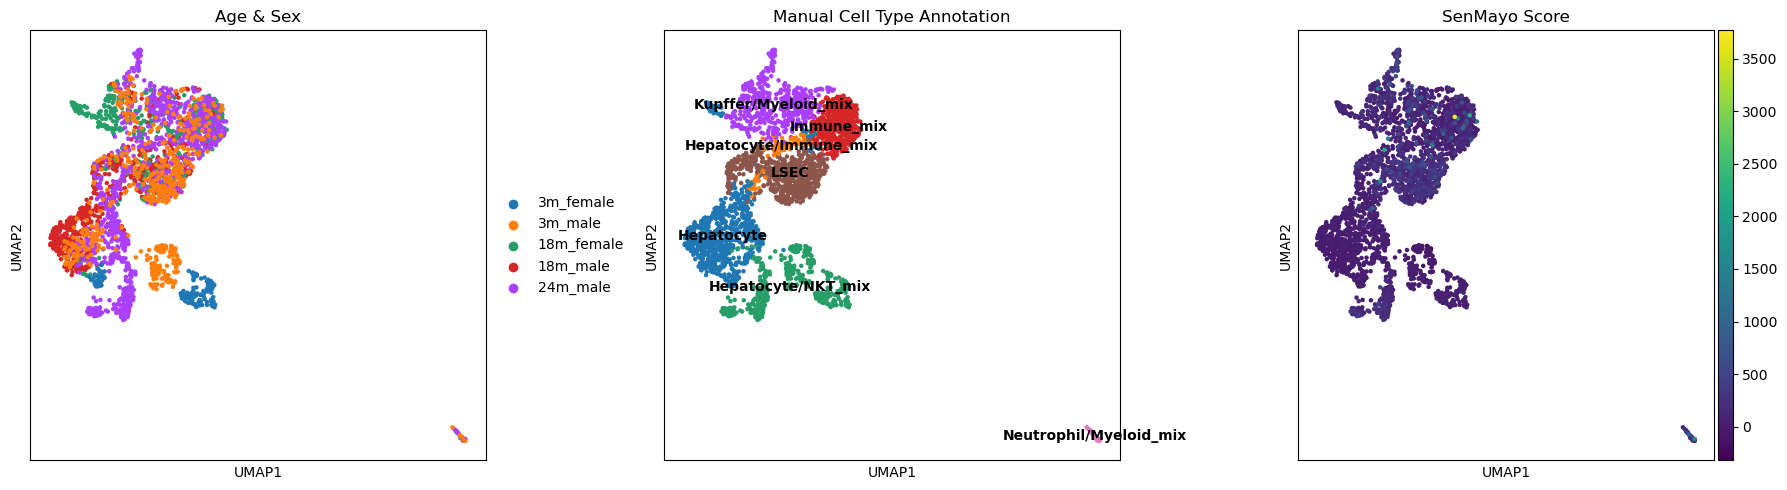

In [ ]:
# Visualize
# 1. Create a figure and a 1x3 grid of subplots (one row, three columns).
# We'll make the figure wider to accommodate the side-by-side plots.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2. Plot each UMAP on a specific subplot (ax).
# The 'axes' object is now a simple list, so we access subplots with a single index.
# We use show=False to prevent each plot from displaying individually.

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0], # Target the first subplot
    show=False,
    legend_loc='right margin', # Legend on the right
    title='Age & Sex'
)

# Second plot (middle): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1], # Target the second subplot
    show=False,
    legend_loc='on data',
    title='Manual Cell Type Annotation'
)

# Third plot (right): SenMayo score
sc.pl.umap(
    adata,
    color='SenMayo_score',
    ax=axes[2], # Target the third subplot
    show=False,
    cmap='viridis',
    title='SenMayo Score'
)

# 3. Adjust spacing and display the final composite figure
plt.tight_layout()
plt.show()

The SenMayo_score calculated indicates the degree to which individual cells in the dataset express a gene signature associated with cellular senescence. In short, it's a per-cell measurement of a specific aging-related biological process.

Here we can see that basically the majority of the cell population is categorized with a low to negative senescence score. This is a biologically expected finding, as senescent cells are typically a rare population in healthy or moderately aged tissues.

There is a scattered group of very low scored cells in the LSEC cluster, possibly belonging to the 3 month male but it is too low a score to be biologically relevant, indicated by the dim green and yellow colors. 

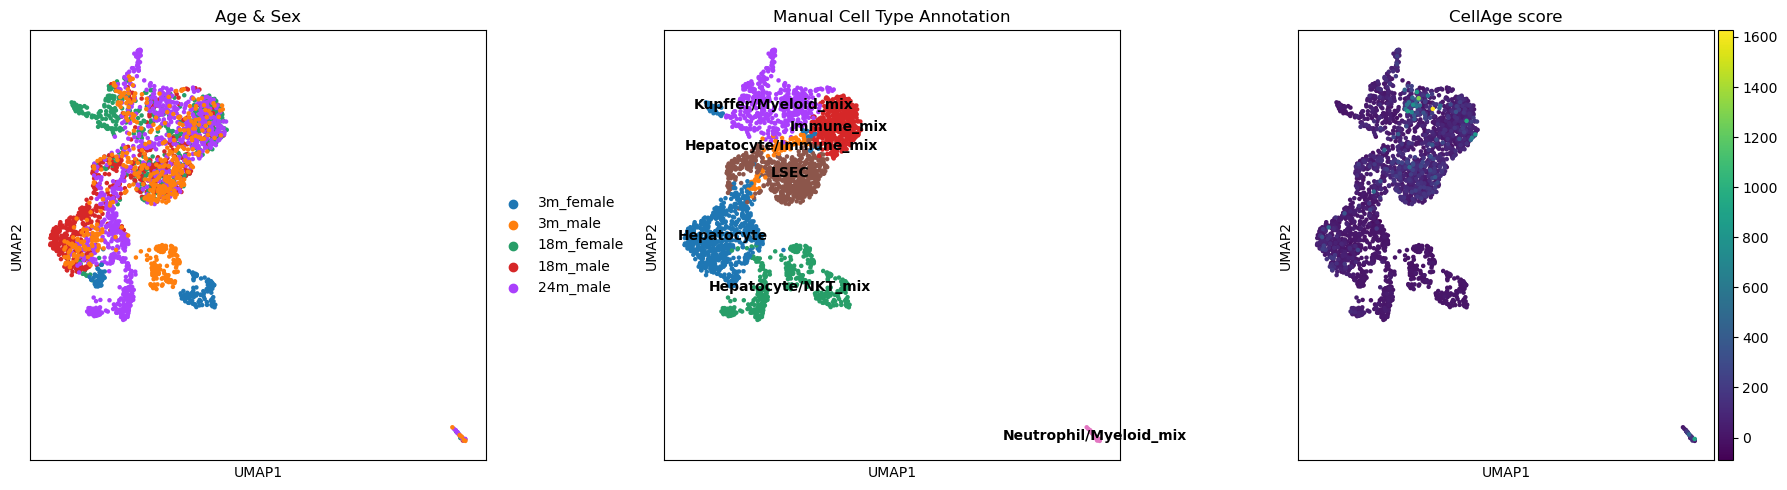

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2. Plot each UMAP on a specific subplot (ax).
# The 'axes' object is now a simple list, so we access subplots with a single index.
# We use show=False to prevent each plot from displaying individually.

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0], # Target the first subplot
    show=False,
    legend_loc='right margin', # Legend on the right
    title='Age & Sex'
)

# Second plot (middle): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1], # Target the second subplot
    show=False,
    legend_loc='on data',
    title='Manual Cell Type Annotation'
)

# Third plot (right): SenMayo score
sc.pl.umap(
    adata,
    color='CellAge_up_score',
    ax=axes[2], # Target the third subplot
    show=False,
    cmap='viridis',
    title='CellAge score'
)

# 3. Adjust spacing and display the final composite figure
plt.tight_layout()
plt.show()


The code reports this: 

39 input query terms found dup hits: This means some human genes (like ATF6) have multiple potential mouse orthologs. mygene reports this ambiguity.

1 input query terms found no hit: ['PHB']: The tool could not find a confident mouse ortholog for the human gene PHB.

There are also 20 genes missing. This is normal since this gene set is much larger than the SenMayo set, where only 2 genes were missing, when comparing it to my liver data.

Here we can see a plot very similar to the SenMayo plot, with perhaps more cells with a higher score than before. 

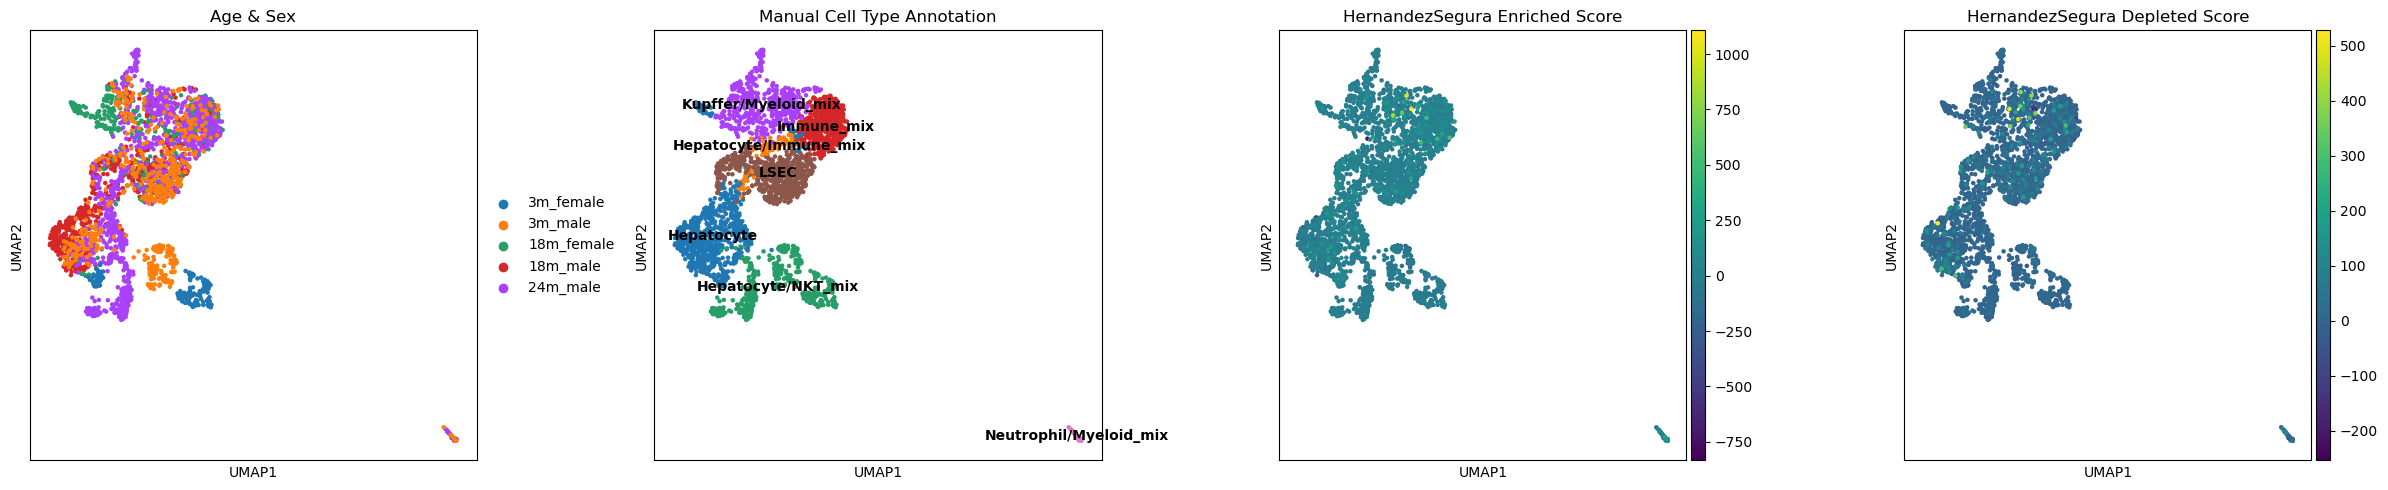

In [9]:
# 1. Create a figure with 4 subplots in a single row.
# Increased the figsize width to accommodate the extra plot.
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# 2. Plot each UMAP on its specific subplot (ax).

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0],
    show=False,
    legend_loc='right margin',
    title='Age & Sex'
)

# Second plot (middle-left): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1],
    show=False,
    # 'on data' can get crowded, 'right margin' might be better if you have many types.
    legend_loc='on data', 
    title='Manual Cell Type Annotation'
)

# Third plot (middle-right): HernandezSegura Enriched Score
sc.pl.umap(
    adata,
    color='HernandezSegura_enriched_score', # Plot only the enriched score here
    ax=axes[2],
    show=False,
    cmap='viridis', # 'viridis' is a good choice for continuous scores
    title='HernandezSegura Enriched Score' # Corrected title
)

# Fourth plot (right): HernandezSegura Depleted Score
sc.pl.umap(
    adata,
    color='HernandezSegura_depleted_score', # Plot only the depleted score here
    ax=axes[3],
    show=False,
    cmap='viridis',
    title='HernandezSegura Depleted Score'
)

# 3. Adjust spacing and display the final composite figure.
plt.tight_layout()
plt.show()

I will now compare the SenMayo, CellAge and Hernandez Segura (both enriched and depleted) predictions scores. This comparison from three different gene sets tells us two different things.


--- Generating Pair Plot ---


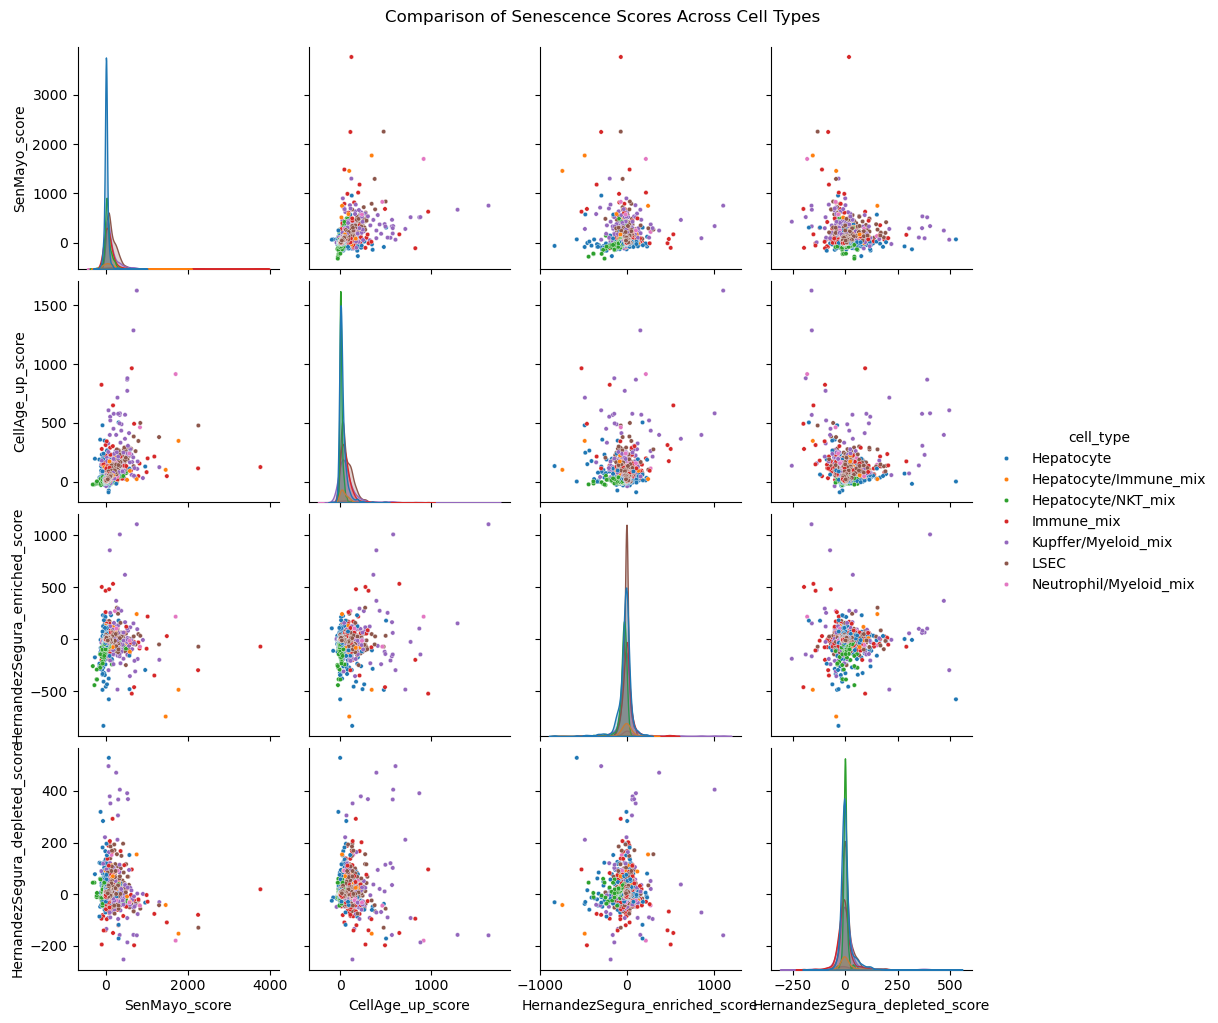

In [12]:
# --- Generating a Pair Plot for All Senescence Scores ---
print("\n--- Generating Pair Plot ---")

# Define the score columns you want to compare
score_columns = ['SenMayo_score', 'CellAge_up_score', 'HernandezSegura_enriched_score', 'HernandezSegura_depleted_score']

# Use seaborn's pairplot function. It will create a grid of scatterplots.
# The 'hue' parameter colors the dots based on the 'cell_type'.
g = sns.pairplot(
    data=adata.obs,
    vars=score_columns,
    hue='cell_type',
    plot_kws={'s': 10} # Adjust point size
)

# Add a title for the entire figure
g.fig.suptitle('Comparison of Senescence Scores Across Cell Types', y=1.02) # y adjusts title position

plt.show()

The diagonal plots show the distribution of a single score for each cell type. We can see that all the distributions of the different signatures score around zero. This is demoralizing for my analyses since it means that the majority of the cells were classified as non senescent. But there are tails of distributions that go to positive values, especially in the SenMayo signature. Meaning that there are in fact, although very few in number, cells that have been classified as senescent. This observation can be made for all other signatures but they have weaker signals of positive senescence in comparison with SenMayo.

The off-diagonal plots each show a 2D scatter plot comparing the scores on the x-axis and y-axis. They compare each score against another. A perfect plot would be a diagonal line of cells, but as we can see this is not the case. The only comparisons that come close are between SenMayo and CellAge to indicating biological relevance, where one scores increases the other also increases. Due to outlier cells that exhibit much larger scores, the reading of the main population is harder. But it can still be inferred, and, apart frmo the comparison between SenMayo and CellAge, we can also see a faint signal between the Hernandez Segura Enriched and both SenMayo and CellAge indicated by the rough cone shape of the cell distribution. It could be nothing though.

Another worthwhile comparison is between the Hernandez Segura enriched and depleted scores. These comparisons ideally would show negative correlations since when one of the scores increases the other should decrease.

Just to double check, I want to see if at least the same cells are being characterized as senescent by both senescent signatures.

--- Defining consistent thresholds for all analyses ---
Thresholds set: SenMayo > 500, CellAge > 500, Hernandez > 100

Total number of cells above each threshold:
is_high_SenMayo      59
is_high_CellAge      19
is_high_Hernandez    90
dtype: int64
---------------------------------------------------------

--- Running Part 2: Analysis of SenMayo vs. CellAge ---

Cell Counts (SenMayo vs. CellAge):
senescence_category_2
Neither              2788
High SenMayo only      52
High CellAge only      12
High in Both            7
Name: count, dtype: int64

Verification: Total High SenMayo (59) = High SenMayo only (52) + High in Both (7)
---------------------------------------------------------
Generating the first plot...


<Figure size 800x700 with 0 Axes>

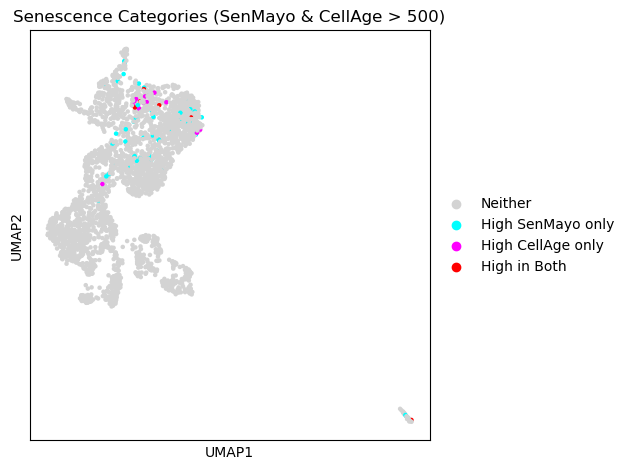


--- Running Part 3: Analysis of All Three Signatures ---

Cell Counts (3 Signatures):
senescence_category_3
Low in All              2708
High in 1 Signature      137
High in 2 Signatures      11
High in All 3              3
Name: count, dtype: int64
---------------------------------------------------------
Generating the second plot...


<Figure size 800x700 with 0 Axes>

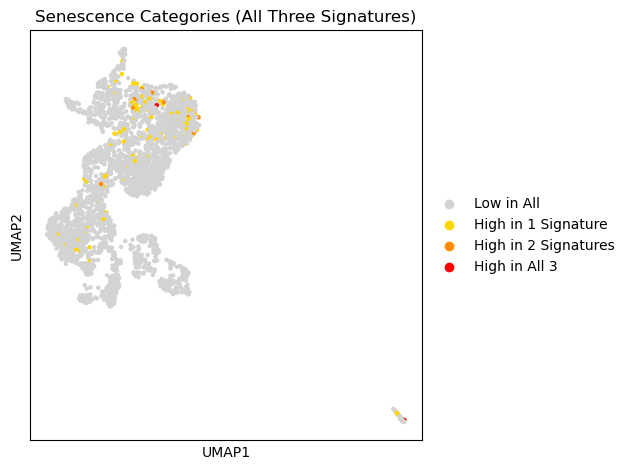


--- Saving the updated AnnData object with consistent flags ---
Successfully saved updated data to 'Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad'


In [30]:
# --- Step 1: Load the data containing ALL scores ---
adata = sc.read_h5ad("Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# ---------------------------------------------------------------------------
# --- PART 1: DEFINE PARAMETERS AND CREATE BOOLEAN FLAGS ---
# All thresholds are defined ONCE here for consistency across the entire script.
# ---------------------------------------------------------------------------
print("--- Defining consistent thresholds for all analyses ---")
senmayo_threshold = 500
cellage_threshold = 500  # Corrected to be consistent with the original 2-score analysis
hernandez_threshold = 100

# Create the combined Hernandez score first
adata.obs['HernandezSegura_combined_score'] = adata.obs['HernandezSegura_enriched_score'] - adata.obs['HernandezSegura_depleted_score']

# Create and store a single set of boolean flags to be used everywhere
adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold
adata.obs['is_high_CellAge'] = adata.obs['CellAge_up_score'] > cellage_threshold
adata.obs['is_high_Hernandez'] = adata.obs['HernandezSegura_combined_score'] > hernandez_threshold

print(f"Thresholds set: SenMayo > {senmayo_threshold}, CellAge > {cellage_threshold}, Hernandez > {hernandez_threshold}")
print("\nTotal number of cells above each threshold:")
print(adata.obs[['is_high_SenMayo', 'is_high_CellAge', 'is_high_Hernandez']].sum())
print("---------------------------------------------------------")

# ---------------------------------------------------------------------------
# --- PART 2: ANALYSIS of SenMayo vs. CellAge ---
# This part now uses the globally defined boolean flags for clarity.
# ---------------------------------------------------------------------------
print("\n--- Running Part 2: Analysis of SenMayo vs. CellAge ---")

# Use the pre-calculated boolean flags
is_high_senmayo = adata.obs['is_high_SenMayo']
is_high_cellage = adata.obs['is_high_CellAge']

# Create the 2-signature categorical column
adata.obs['senescence_category_2'] = 'Neither'
adata.obs.loc[is_high_senmayo, 'senescence_category_2'] = 'High SenMayo only'
adata.obs.loc[is_high_cellage, 'senescence_category_2'] = 'High CellAge only'
adata.obs.loc[is_high_senmayo & is_high_cellage, 'senescence_category_2'] = 'High in Both'

adata.obs['senescence_category_2'] = pd.Categorical(
    adata.obs['senescence_category_2'],
    categories=['Neither', 'High SenMayo only', 'High CellAge only', 'High in Both'], ordered=True)

# Quantify and print the results
category_counts_2 = adata.obs['senescence_category_2'].value_counts()
print("\nCell Counts (SenMayo vs. CellAge):")
print(category_counts_2)
print("\nVerification: Total High SenMayo ({}) = High SenMayo only ({}) + High in Both ({})".format(
    is_high_senmayo.sum(),
    category_counts_2.get('High SenMayo only', 0),
    category_counts_2.get('High in Both', 0)
))
print("---------------------------------------------------------")

# Visualize the 2-score categories on a UMAP plot
print("Generating the first plot...")
plt.figure(figsize=(8, 7))
sc.pl.umap(adata, color='senescence_category_2', title=f'Senescence Categories (SenMayo & CellAge > {senmayo_threshold})',
           palette={'Neither': 'lightgrey', 'High SenMayo only': 'cyan', 'High CellAge only': 'magenta', 'High in Both': 'red'}, show=False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# --- PART 3: ANALYSIS of All Three Signatures ---
# ---------------------------------------------------------------------------
print("\n--- Running Part 3: Analysis of All Three Signatures ---")

# Use the boolean flags to sum the conditions met by each cell
sum_of_conditions = adata.obs['is_high_SenMayo'].astype(int) + \
                    adata.obs['is_high_CellAge'].astype(int) + \
                    adata.obs['is_high_Hernandez'].astype(int)

# Create the 3-signature categorical column
adata.obs['senescence_category_3'] = 'Low in All'
adata.obs.loc[sum_of_conditions == 1, 'senescence_category_3'] = 'High in 1 Signature'
adata.obs.loc[sum_of_conditions == 2, 'senescence_category_3'] = 'High in 2 Signatures'
adata.obs.loc[sum_of_conditions == 3, 'senescence_category_3'] = 'High in All 3'

adata.obs['senescence_category_3'] = pd.Categorical(
    adata.obs['senescence_category_3'],
    categories=['Low in All', 'High in 1 Signature', 'High in 2 Signatures', 'High in All 3'], ordered=True)

print("\nCell Counts (3 Signatures):")
print(adata.obs['senescence_category_3'].value_counts())
print("---------------------------------------------------------")

# Visualize the 3-score categories on a UMAP plot
print("Generating the second plot...")
plt.figure(figsize=(8, 7))
sc.pl.umap(adata, color='senescence_category_3', title='Senescence Categories (All Three Signatures)',
           palette={'Low in All': 'lightgrey', 'High in 1 Signature': 'gold', 'High in 2 Signatures': 'darkorange', 'High in All 3': 'red'}, show=False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# --- PART 4: SAVE THE FINAL ANNDATA OBJECT ---
# ---------------------------------------------------------------------------
print("\n--- Saving the updated AnnData object with consistent flags ---")
output_filename = "Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"
adata.write_h5ad(output_filename)
print(f"Successfully saved updated data to '{output_filename}'")

Here we can see that from the whole dataset, the only cells that scored above 500/250/100 (thresholds) in the three signatures are devided by 131 cells from only one signature, 35 cells from two signatures, and 3 cells that are from the three signatures. These three cells show the best corroboration of their senescent nature.

Besides this result demonstrating the lack of senescence prediction or, if the results are biologically relevant since I have not yet done a batch correction, the lack of senescent cells, it also demonstrates how much better SenMayo is than CellAge at identifying senescence, even though it is comprised of fewer marker genes (125 in comparison with 503 total).

I now want to see if these "highly" correlated cells belong in fact to mice that are old, or at least older than 3 months, which is our starting sample.

In [21]:
# --- Step 1: Load the data containing ALL scores and annotations ---
# IMPORTANT: Use the file that contains the Hernandez Segura scores.
adata = sc.read_h5ad("Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# ---------------------------------------------------------------------------
# --- PART 1: ORIGINAL ANALYSIS (SenMayo vs. CellAge) ---
# ---------------------------------------------------------------------------
print("\n--- Running Part 1: Crosstab for SenMayo vs. CellAge ---")

# --- (Re)create the 'senescence_category' for the 2-score comparison ---
threshold_2_scores = 500
is_high_senmayo = adata.obs['SenMayo_score'] > threshold_2_scores
is_high_cellage = adata.obs['CellAge_up_score'] > threshold_2_scores

adata.obs['senescence_category_2'] = 'Neither'
adata.obs.loc[is_high_senmayo, 'senescence_category_2'] = 'High SenMayo only'
adata.obs.loc[is_high_cellage, 'senescence_category_2'] = 'High CellAge only'
adata.obs.loc[is_high_senmayo & is_high_cellage, 'senescence_category_2'] = 'High in Both'

# --- Create and print the crosstab tables for the 2-score comparison ---
# Absolute counts
contingency_table_2 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_2']
)
print("\n--- Absolute Count of Cells (SenMayo vs. CellAge) ---")
print(contingency_table_2)
print("----------------------------------------------------\n")

# Normalized proportions
proportion_table_2 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_2'], 
    normalize='index'
).multiply(100).round(2)
print("--- Percentage of Cells (SenMayo vs. CellAge, within each age_sex group) ---")
print(proportion_table_2)
print("--------------------------------------------------------------------------\n")


# ---------------------------------------------------------------------------
# --- PART 2: NEW ANALYSIS (Incorporating Hernandez Segura) ---
# ---------------------------------------------------------------------------
print("\n--- Running Part 2: Crosstab for All Three Signatures ---")

# --- Create a combined score for the Hernandez Segura signature ---
adata.obs['HernandezSegura_combined_score'] = adata.obs['HernandezSegura_enriched_score'] - adata.obs['HernandezSegura_depleted_score']

# --- Define thresholds and categorize cells for THREE signatures ---
senmayo_threshold = 500
cellage_threshold = 250
hernandez_threshold = 100

is_high_senmayo_3 = adata.obs['SenMayo_score'] > senmayo_threshold
is_high_cellage_3 = adata.obs['CellAge_up_score'] > cellage_threshold
is_high_hernandez_3 = adata.obs['HernandezSegura_combined_score'] > hernandez_threshold

sum_of_conditions = is_high_senmayo_3.astype(int) + is_high_cellage_3.astype(int) + is_high_hernandez_3.astype(int)

# --- Create the new categorical column for the 3-score comparison ---
adata.obs['senescence_category_3'] = 'Low in All'
adata.obs.loc[sum_of_conditions == 1, 'senescence_category_3'] = 'High in 1 Signature'
adata.obs.loc[sum_of_conditions == 2, 'senescence_category_3'] = 'High in 2 Signatures'
adata.obs.loc[sum_of_conditions == 3, 'senescence_category_3'] = 'High in All 3'

# --- Create and print the crosstab tables for the 3-score comparison ---
# Absolute counts
contingency_table_3 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_3']
)
print("\n--- Absolute Count of Cells (3 Signatures) ---")
print(contingency_table_3)
print("-----------------------------------------------\n")

# Normalized proportions
proportion_table_3 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_3'], 
    normalize='index'
).multiply(100).round(2)
print("--- Percentage of Cells (3 Signatures, within each age_sex group) ---")
print(proportion_table_3)
print("---------------------------------------------------------------------\n")


--- Running Part 1: Crosstab for SenMayo vs. CellAge ---

--- Absolute Count of Cells (SenMayo vs. CellAge) ---
senescence_category_2  High CellAge only  High SenMayo only  High in Both  \
age_sex                                                                     
3m_female                              0                  0             0   
3m_male                                0                  0             0   
18m_female                             0                 12             0   
18m_male                               0                  8             0   
24m_male                              12                 32             7   

senescence_category_2  Neither  
age_sex                         
3m_female                  161  
3m_male                    570  
18m_female                 521  
18m_male                   639  
24m_male                   897  
----------------------------------------------------

--- Percentage of Cells (SenMayo vs. CellAge, within each age_

Here we can see that the bigger proportion of cells characterized as senescent are from the 18 months mice onwards, with the biggest group of senescence associated with the 24 month mice. Even if the highest number of sampled cells belong to the 24 month old mice, the normalization makes the data significant. Also we can see a definite increase in cells classified as senescent with age. For example, the proportion of cells that were classified as senescent from a single signature (as a combination of the three signatures) increase with mice ages.  

So now we have identified a possible age related senescent signature in our data.

Now I want to see per cell how many reads are associated with the genes that classified it as senescent by the SenMayo signature, specifically, in an effort to identify one or more genes that are overexpressed in these cells in comparison with others. To facilitate observation and study of the data I will compute the overall percentage of cells that have reads above zero for any gene included in SenMayo. 

And i wonder if it also makes sense to, from the cells identified by SenMayo, identify and compare not only the genes that are more expressed but the genes that are least expressed between the cells that belong to different age groups.

Top 10 most frequently expressed SenMayo genes:
         gene  percent_expressing
25       Ctsb           53.760056
55     Igfbp4           52.360965
48      Hmgb1           49.317943
76        Mif           45.225603
51       Igf1           42.427422
8          C3           40.608604
107  Tnfrsf1a           33.823015
24     Ctnnb1           33.263379
75       Lcp1           32.563834
70     Iqgap2           32.249038


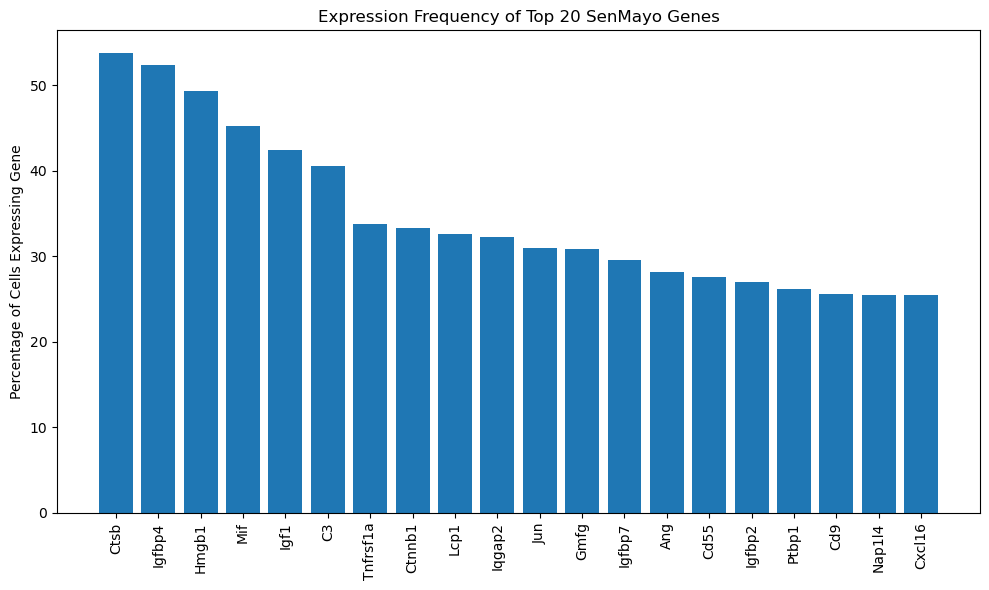

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

# Load the SenMayo gene set (assuming you have the .gmt file)
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
except FileNotFoundError:
    print("SAUL_SEN_MAYO.v2025.1.Mm.gmt not found. Please ensure the file is in the correct path.")
    senmayo_genes = [] # Set to empty list to avoid further errors


if senmayo_genes:
    # Ensure we only consider genes present in our dataset
    senmayo_genes_in_adata = [gene for gene in senmayo_genes if gene in adata.var_names]

    # Get the expression data for the SenMayo genes
    senmayo_expression = adata[:, senmayo_genes_in_adata].X

    # First, check if the data is in a sparse format. If so, convert it.
    # If it's already a dense numpy array, just use it as is.
    if scipy.sparse.issparse(senmayo_expression):
        # This will run if your matrix is sparse
        expression_dense = senmayo_expression.toarray()
    else:
        # This will run in your case, where the matrix is already dense
        expression_dense = senmayo_expression

    # Calculate the percentage of cells with non-zero reads for each gene
    # We now operate on the 'expression_dense' variable which is guaranteed to be a numpy array
    percent_expressing = (expression_dense > 0).mean(axis=0) * 100
    # ------------------------------------

    # Create a DataFrame for easy viewing and sorting
    percent_expressing_df = pd.DataFrame({
        'gene': senmayo_genes_in_adata,
        'percent_expressing': percent_expressing
    }).sort_values(by='percent_expressing', ascending=False)

    print("Top 10 most frequently expressed SenMayo genes:")
    print(percent_expressing_df.head(10))

    # Visualize the results
    plt.figure(figsize=(10, 6))
    # Plot the top 20 genes for clarity
    top_genes_df = percent_expressing_df.head(20)
    plt.bar(top_genes_df['gene'], top_genes_df['percent_expressing'])
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of Cells Expressing Gene")
    plt.title("Expression Frequency of Top 20 SenMayo Genes")
    plt.tight_layout()
    plt.show()

--- Identifying the top 20 most expressed SenMayo genes ---
Top 20 SenMayo genes identified.
['Ctsb', 'Igfbp4', 'Hmgb1', 'Mif', 'Igf1', 'C3', 'Tnfrsf1a', 'Ctnnb1', 'Lcp1', 'Iqgap2', 'Jun', 'Gmfg', 'Igfbp7', 'Ang', 'Cd55', 'Igfbp2', 'Ptbp1', 'Cd9', 'Nap1l4', 'Cxcl16']

--- Subsetting for the 59 high SenMayo cells ---
Analysis will be performed on 59 cells.

--- Calculating expression percentages within age groups ---

--- Generating plot ---


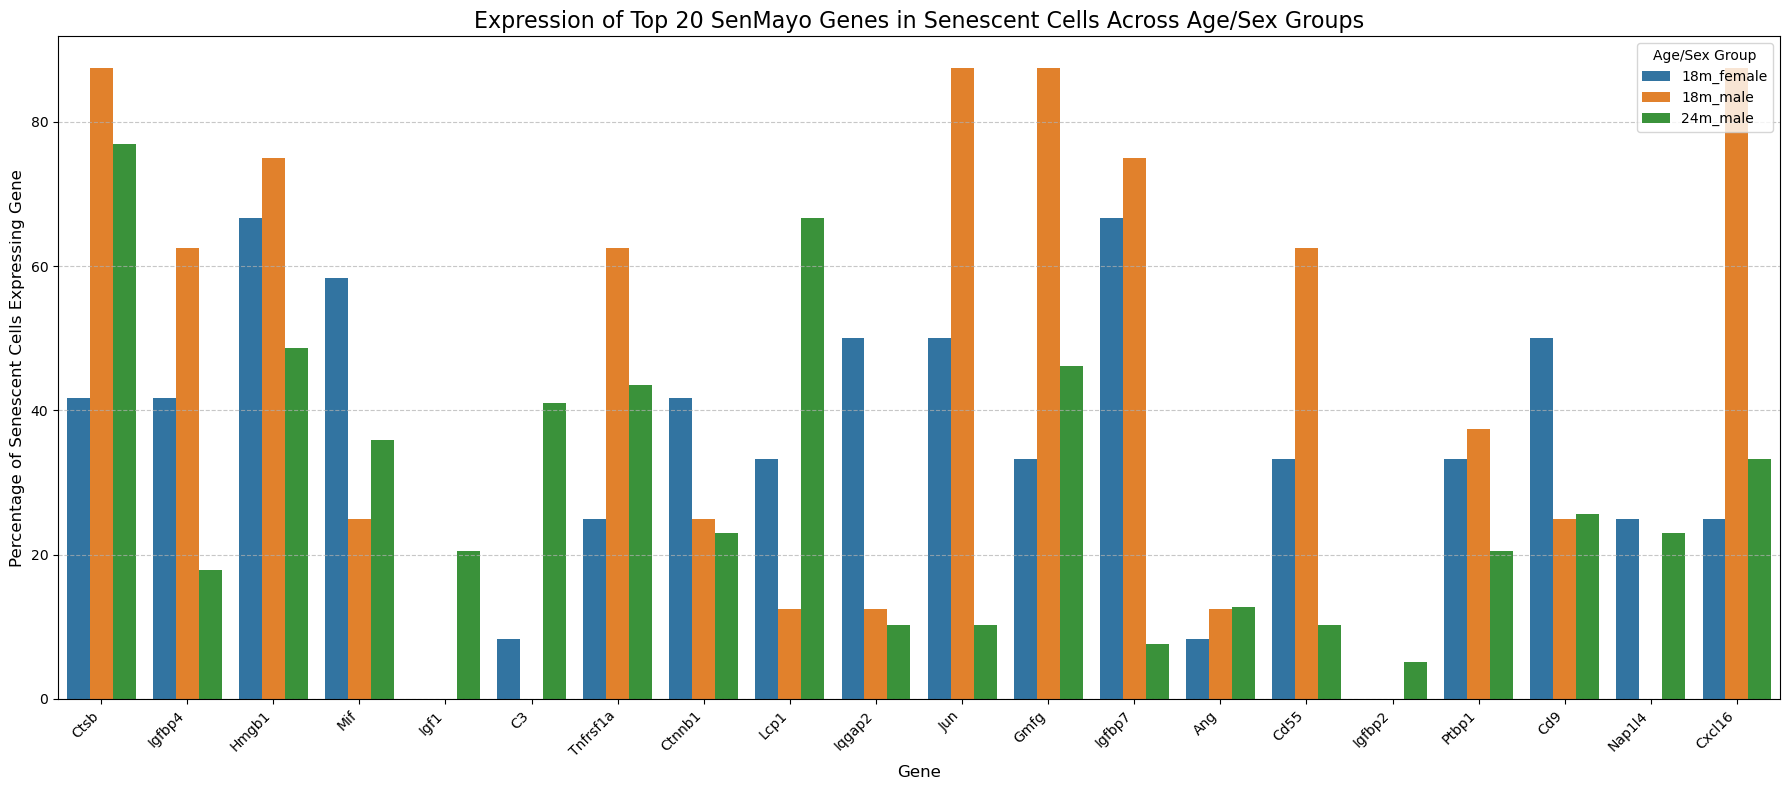

In [31]:
# --- Step 1: Load the annotated data with the senescence flags ---
adata = sc.read_h5ad("Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")


# --- Step 2: Identify the Top 20 Most Frequently Expressed SenMayo Genes ---
# We do this across the ENTIRE dataset to get a robust list of the most
# relevant genes from the signature.

print("--- Identifying the top 20 most expressed SenMayo genes ---")
# Load the SenMayo gene set
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
except FileNotFoundError:
    print("Error: SAUL_SEN_MAYO.v2025.1.Mm.gmt not found.")
    senmayo_genes = []

if senmayo_genes:
    # Filter for genes present in our data
    senmayo_genes_in_adata = [gene for gene in senmayo_genes if gene in adata.var_names]
    
    # Get expression data for these genes from all cells
    full_expression = adata[:, senmayo_genes_in_adata].X

    # Handle sparse vs. dense matrix formats
    if scipy.sparse.issparse(full_expression):
        full_expression_dense = full_expression.toarray()
    else:
        full_expression_dense = full_expression

    # Calculate percentage of all cells expressing each gene
    percent_expressing_all = (full_expression_dense > 0).mean(axis=0) * 100
    
    # Create a DataFrame and get the top 20 gene names
    percent_expressing_df = pd.DataFrame({
        'gene': senmayo_genes_in_adata,
        'percent_expressing': percent_expressing_all
    }).sort_values(by='percent_expressing', ascending=False)
    
    top_20_senmayo_genes = percent_expressing_df['gene'].head(20).tolist()
    print("Top 20 SenMayo genes identified.")
    print(top_20_senmayo_genes)
else:
    top_20_senmayo_genes = [] # Ensure the variable exists


# --- Step 3: Subset the data to only include the high SenMayo cells ---
if top_20_senmayo_genes:
    print("\n--- Subsetting for the 59 high SenMayo cells ---")
    senmayo_cells_adata = adata[adata.obs['is_high_SenMayo']].copy()
    print(f"Analysis will be performed on {senmayo_cells_adata.n_obs} cells.")

    # --- Step 4: Calculate expression percentage of top 20 genes, grouped by age_sex ---
    print("\n--- Calculating expression percentages within age groups ---")
    
    # Get the unique age/sex groups from our senescent cell subset
    age_sex_groups = senmayo_cells_adata.obs['age_sex'].unique()
    
    # This list will store our results
    results_list = []

    # Loop through each age/sex group
    for group in age_sex_groups:
        # Get the cells belonging to the current group
        group_adata = senmayo_cells_adata[senmayo_cells_adata.obs['age_sex'] == group]
        
        # Get expression data for the top 20 genes for this group
        group_expression = group_adata[:, top_20_senmayo_genes].X
        
        # Handle sparse/dense format
        if scipy.sparse.issparse(group_expression):
            group_expression_dense = group_expression.toarray()
        else:
            group_expression_dense = group_expression
        
        # If there are cells in the group, calculate percentages
        if group_expression_dense.shape[0] > 0:
            # Calculate the percentage of cells IN THIS GROUP expressing each gene
            group_percent_expressing = (group_expression_dense > 0).mean(axis=0) * 100
        else: # Handle cases where a group might have no senescent cells
            group_percent_expressing = [0] * len(top_20_senmayo_genes)

        # Store the results
        for i, gene in enumerate(top_20_senmayo_genes):
            results_list.append({
                'gene': gene,
                'age_sex': group,
                'percent_expressing': group_percent_expressing[i]
            })

    # Convert the results to a DataFrame for easy plotting
    results_df = pd.DataFrame(results_list)

    # --- Step 5: Visualize the results ---
    print("\n--- Generating plot ---")
    plt.figure(figsize=(18, 8))
    
    sns.barplot(
        data=results_df,
        x='gene',
        y='percent_expressing',
        hue='age_sex'
    )
    
    plt.title('Expression of Top 20 SenMayo Genes in Senescent Cells Across Age/Sex Groups', fontsize=16)
    plt.ylabel('Percentage of Senescent Cells Expressing Gene', fontsize=12)
    plt.xlabel('Gene', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.legend(title='Age/Sex Group')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

As we saw earlier, no signature apart from Hernandez-Segura identified senescence in 3 month old mice. So the SenMayo cells are only composed of 18 and 24 month old mice. 

First of all we can see that there is a significant differential expression in certain genes like Ctsb and Jun, among others, between the different sexes at 18 months. Between the same sex at different ages we can also see a change in expression in the Jun and Gmfg genes, among others. Since we know that all these genes have been characterized as senescence adjacent since they belong to the SenMayo signature this differential expression along the sex and age graphs can be an indication of possible causes or consequences or this phenotype.